# Project 2 for CarND: Traffic Sign Classifier

## Objectives
- use the same notebook used for MNIST database to classify traffic signs
- use a new function to normalize the imput
- investigate the classification accuracy for Adam Optimizer and Gradient Descent for a range of drop rates and learning rates

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
tf.__version__

'0.12.1'

<img align="left" src="files/old.png"> **Load data**

In [3]:
training_file = './data/train2.p'
testing_file = './data/test2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

<img align="left" src="files/old.png"> **Standardize naming** 

In [4]:
xtr = train['features']
ytr = train['labels']

xva, xte, yva, yte = train_test_split(test['features'], test['labels'], test_size=0.5)

<img align="left" src="files/old.png"> **One hot encoding**

In [5]:
encoder = LabelBinarizer()
encoder.fit(ytr)
ytr = encoder.transform(ytr).astype(float)
yte = encoder.transform(yte).astype(float)
yva = encoder.transform(yva).astype(float)

<img align="left" src="files/new.png"> **Normalize the input**

In [6]:
def normalize(x_in,y_in):
    
    x_out = []
    y_out = []
    for i, (image, label) in enumerate(zip(x_in, y_in)):
        zeros = np.zeros((32,32,3))
        norm_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        x_out.append(norm_image)
        y_out.append(label)

    return x_out, y_out

In [7]:
xtr, ytr = normalize(xtr,ytr)
xte, yte = normalize(xte,yte)
xva, yva = normalize(xva,yva)

<img align="left" src="files/old.png"> **Convolutional layer**

In [8]:
def convolutional_layer(input, filter_size, in_channels, out_channels, conv_strides, pool_kernel, pool_strides):

    filter_shape = [filter_size, filter_size, in_channels, out_channels]
    biases_shape = [out_channels]
    
    filter = tf.Variable(tf.truncated_normal(filter_shape))
    biases = tf.Variable(tf.truncated_normal(biases_shape))
    
    result = tf.nn.conv2d(input, filter, strides=conv_strides, padding='SAME') + biases
    result = tf.nn.max_pool(value=result,ksize=pool_kernel,strides=pool_strides,padding='SAME')
    result = tf.nn.relu(result)
    
    return result

<img align="left" src="files/old.png"> **Flatten the layer**

In [9]:
def flatten_layer(input):
    
    layer_shape = input.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    
    return layer_flat, num_features

<img align="left" src="files/old.png"> **Fully connected layer**

In [10]:
def fully_connected_layer(input, num_features, num_outputs):
    
    weights = tf.Variable(tf.truncated_normal([num_features, num_outputs], stddev=0.05))
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

    output = tf.matmul(input, weights) + biases
    
    return output

<img align="left" src="files/old.png"> **Optimize**

In [11]:
def optimize(optimizer, l_rate, keep_probability, iterations, x_train, y_train, batch_size):
    
    for i in range(0,iterations):  
        x1, x2, y1, y2 = train_test_split(x_train, y_train, train_size=batch_size, random_state=i)        
        sess.run(optimizer, feed_dict = {x: x1, y: y1, learning_rate: l_rate, keep_prob: keep_probability})

<img align="left" src="files/old.png"> **Test accuracy**

In [12]:
def test_accuracy(logits,x_data,y_data):
    
    y_pred = tf.nn.softmax(logits)
    
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    y_true_cls = tf.argmax(y, dimension=1)

    prediction = tf.equal(y_pred_cls, y_true_cls)    
    
    num_examples = len(x_data)
    batch_size = 8192
    all_predictions = []
    
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        all_predictions.extend(sess.run(prediction, feed_dict = {x: batch_x, y: batch_y, keep_prob: 1})) 
    
    return np.mean(all_predictions)

## Build the computational graph using the defined functions

In [13]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, 43])

learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

conv_1_out = convolutional_layer(x, 5, 3, 32, [1, 1, 1, 1], [1, 2, 2, 1], [1, 2, 2, 1])
conv_2_out = convolutional_layer(conv_1_out, 5, 32, 64, [1, 1, 1, 1], [1, 2, 2, 1], [1, 2, 2, 1])

layer_flat, num_features = flatten_layer(conv_2_out)

layer_1 = fully_connected_layer(layer_flat, num_features, 512)
layer_1 = tf.nn.relu(layer_1)

layer_1   = tf.nn.dropout(layer_1, keep_prob)

logits = fully_connected_layer(layer_1, 512, 43)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits,y)
cost = tf.reduce_mean(cross_entropy)

grad = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
adam = tf.train.AdamOptimizer(learning_rate).minimize(cost)

<img align="left" src="files/old.png"> **Same**

In [14]:
def run_training(logits, optimizer, l_rate, keep, tick_size, n_ticks, xtr, ytr, xte, yte, train_batch, verbose):
    
    sess.run(tf.global_variables_initializer())
    
    result = [[],[],[],0]

    for i in range(1,n_ticks+1):    
        optimize(optimizer, l_rate, keep, tick_size, xtr, ytr, train_batch)        
        tr_a = test_accuracy(logits,xtr,ytr)
        te_a = test_accuracy(logits,xte,yte)
        result[0].append(tr_a)
        result[1].append(te_a)
        result[2].append(i*tick_size)
        if verbose:
            print i, tr_a, te_a
    result[3] = test_accuracy(logits,xva,yva)
    return result

In [15]:
sess = tf.Session()

## Gradient Descent accuracy rate

In [16]:
batch = 512
tick = 10000
n_ticks = 20
verb = 0

In [17]:
gr_r1, gr_e1, gr_t1, gr_v1 = run_training(logits, grad, 10**-2, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [18]:
gr_r2, gr_e2, gr_t2, gr_v2 = run_training(logits, grad, 10**-3, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [19]:
gr_r3, gr_e3, gr_t3, gr_v3 = run_training(logits, grad, 10**-4, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

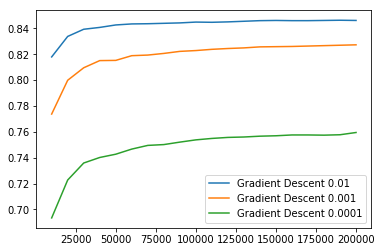

In [20]:
plt.plot(gr_t1,gr_e1, label='Gradient Descent 0.01')
plt.plot(gr_t2,gr_e2, label='Gradient Descent 0.001')
plt.plot(gr_t3,gr_e3, label='Gradient Descent 0.0001')
plt.legend()
plt.show()

## Adam Optimizer

In [21]:
ad_r1, ad_e1, ad_t1, ad_v1 = run_training(logits, adam, 10**-2, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [22]:
ad_r2, ad_e2, ad_t2, ad_v2 = run_training(logits, adam, 10**-3, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [23]:
ad_r3, ad_e3, ad_t3, ad_v3 = run_training(logits, adam, 10**-4, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

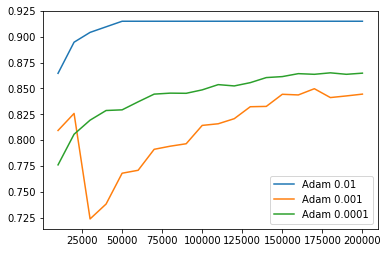

In [24]:
plt.plot(ad_t1,ad_e1, label='Adam 0.01')
plt.plot(ad_t2,ad_e2, label='Adam 0.001')
plt.plot(ad_t3,ad_e3, label='Adam 0.0001')
plt.legend()
plt.show()

In [25]:
gr_v1, gr_v2, gr_v3

(0.84861441013460015, 0.82644497228820268, 0.75692794932699925)

In [26]:
ad_v1, ad_v2, ad_v3

(0.90910530482977037, 0.85035629453681705, 0.86603325415676957)

## Learning rate too high

In [27]:
batch = 512
tick = 10000
n_ticks = 10
verb = 0

In [28]:
gr_r4, gr_e4, gr_t4, gr_v4 = run_training(logits, grad, 0.02, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [29]:
ad_r4, ad_e4, ad_t4, ad_v4 = run_training(logits, adam, 0.02, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

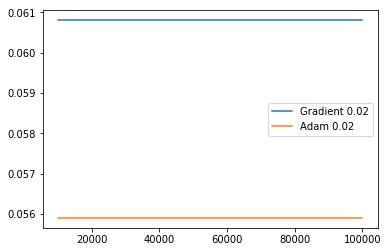

In [30]:
plt.plot(gr_t4,gr_e4, label='Gradient 0.02')
plt.plot(ad_t4,ad_e4, label='Adam 0.02')
plt.legend()
plt.show()

## Gradient Descent vs Adam Optimizer at the same learning rate

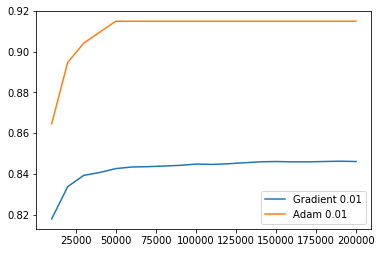

In [41]:
plt.plot(gr_t1,gr_e1, label='Gradient 0.01')
plt.plot(ad_t1,ad_e1, label='Adam 0.01')
plt.legend()
plt.show()

## Gradient Descent  drop rate

In [32]:
batch = 512
tick = 10000
n_ticks = 20
verb = 0

In [33]:
gr_r5, gr_e5, gr_t5, gr_v5 = run_training(logits, grad, 10**-2, 0.8, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [34]:
gr_r6, gr_e6, gr_t6, gr_v6 = run_training(logits, grad, 10**-2, 0.6, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [35]:
gr_r7, gr_e7, gr_t7, gr_v7 = run_training(logits, grad, 10**-2, 0.4, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [42]:
gr_r8, gr_e8, gr_t8, gr_v8 = run_training(logits, grad, 10**-2, 0.2, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

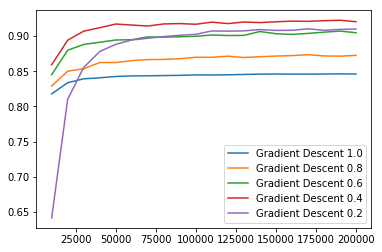

In [43]:
plt.plot(gr_t1,gr_e1, label='Gradient Descent 1.0')
plt.plot(gr_t5,gr_e5, label='Gradient Descent 0.8')
plt.plot(gr_t6,gr_e6, label='Gradient Descent 0.6')
plt.plot(gr_t7,gr_e7, label='Gradient Descent 0.4')
plt.plot(gr_t8,gr_e8, label='Gradient Descent 0.2')
plt.legend()
plt.show()

## Adam Optimizer drop rate

In [44]:
batch = 512
tick = 3000
n_ticks = 20
verb = 0

In [45]:
ad_r5, ad_e5, ad_t5, ad_v5 = run_training(logits, adam, 10**-2, 1.0, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [46]:
ad_r6, ad_e6, ad_t6, ad_v6 = run_training(logits, adam, 10**-2, 0.8, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [47]:
ad_r7, ad_e7, ad_t7, ad_v7 = run_training(logits, adam, 10**-2, 0.6, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [48]:
ad_r8, ad_e8, ad_t8, ad_v8 = run_training(logits, adam, 10**-2, 0.4, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

In [49]:
ad_r9, ad_e9, ad_t9, ad_v9 = run_training(logits, adam, 10**-2, 0.2, tick, n_ticks, xtr, ytr, xte, yte, batch, verb)

#### With keep rate of 0.2 it fails to learn

In [51]:
ad_v5, ad_v6, ad_v7, ad_v8, ad_v9

(0.87347585114806015,
 0.87173396674584325,
 0.74663499604117178,
 0.82486144101346004,
 0.05669041963578781)

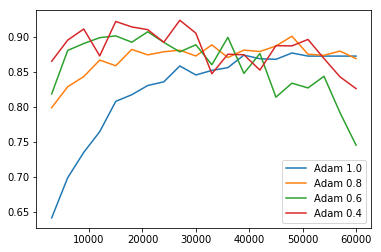

In [52]:
plt.plot(ad_t5,ad_e5, label='Adam 1.0')
plt.plot(ad_t6,ad_e6, label='Adam 0.8')
plt.plot(ad_t7,ad_e7, label='Adam 0.6')
plt.plot(ad_t8,ad_e8, label='Adam 0.4')
plt.legend()
plt.show()